# Gesture Recognition


**Problem Statement**

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |



### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [0]:
%pip install scikit-image


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-200ecc1c-b543-47ad-803e-d069978e1d3e
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: lazy-loader
    Found existing installation: lazy_loader 0.3
    Not uninstalling lazy-loader at /databricks/python3/lib/python3.10/site-packages, o

In [0]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.applications import mobilenet
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [0]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
# Use once and comment the below code
# import zipfile
# path_to_zip_file='/dbfs/FileStore/tables/gesturerecog/Project_data.zip'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall('/dbfs/FileStore/tables/gesture_recog/datasets/')

In [0]:
%fs ls dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/



path,name,size,modificationTime
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/,train/,0,1713889261000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train.csv,train.csv,39651,1713889261000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/val/,val/,0,1713890527000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/val.csv,val.csv,5970,1713890527000


In [0]:
%fs ls dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/


path,name,size,modificationTime
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/,WIN_20180907_15_35_09_Pro_Right Swipe_new/,0,1713889261000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/,WIN_20180907_15_38_17_Pro_Left Swipe_new_Left Swipe_new/,0,1713889263000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_38_24_Pro_Right Swipe_new/,WIN_20180907_15_38_24_Pro_Right Swipe_new/,0,1713889265000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_38_35_Pro_Thumbs Down_new/,WIN_20180907_15_38_35_Pro_Thumbs Down_new/,0,1713889267000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_39_51_Pro_Stop Gesture_new/,WIN_20180907_15_39_51_Pro_Stop Gesture_new/,0,1713889269000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_39_54_Pro_Thumbs Up_new/,WIN_20180907_15_39_54_Pro_Thumbs Up_new/,0,1713889271000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_40_26_Pro_Thumbs Down_new/,WIN_20180907_15_40_26_Pro_Thumbs Down_new/,0,1713889273000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_40_55_Pro_Thumbs Up_new/,WIN_20180907_15_40_55_Pro_Thumbs Up_new/,0,1713889275000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_41_54_Pro_Right Swipe_new/,WIN_20180907_15_41_54_Pro_Right Swipe_new/,0,1713889277000
dbfs:/FileStore/tables/gesture_recog/datasets/Project_data/train/WIN_20180907_15_43_00_Pro_Left Swipe_new_Left Swipe_new/,WIN_20180907_15_43_00_Pro_Left Swipe_new_Left Swipe_new/,0,1713889279000


In [0]:
train_doc = np.random.permutation(open('/dbfs/FileStore/tables/gesture_recog/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/dbfs/FileStore/tables/gesture_recog/datasets/Project_data/val.csv').readlines())
batch_size = 64

In [0]:
## Checking the GPU configuration
!nvidia-smi

Thu Apr 25 01:36:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           Off | 00000001:00:00.0 Off |                    0 |
| N/A   24C    P0              24W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

All the required Util functions are defined below to pre-process the data 

In [0]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels    

def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # logic for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)   

def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))
    
def stepsperepoch(num_train_sequences,num_val_sequences,batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return (steps_per_epoch,validation_steps)            

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [0]:
curr_dt_time = datetime.datetime.now()
train_path = '/dbfs/FileStore/tables/gesture_recog/datasets/Project_data/train/'
val_path = '/dbfs/FileStore/tables/gesture_recog/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [0]:
# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


In [0]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /dbfs/FileStore/tables/gesture_recog/datasets/Project_data/train/ ; batch size = 64
(64, 20, 100, 100, 3)
Source path =  /dbfs/FileStore/tables/gesture_recog/datasets/Project_data/val ; batch size = 64
(64, 20, 100, 100, 3)


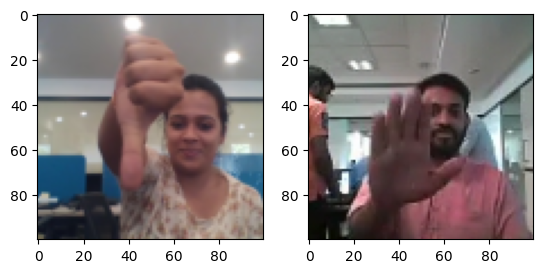

In [0]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[28,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[40,10,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Base Model (CNN CONV3D )


In [0]:
#write your model here

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model = Sequential([
Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
MaxPooling3D(make3dFilter(2), padding='same'),
BatchNormalization(),

Conv3D(32, make3dFilter(3), activation='relu'),
MaxPooling3D(pool_size=(1,2,2), padding='same'),
BatchNormalization(),

Conv3D(64, make3dFilter(3), activation='relu'),
MaxPooling3D(pool_size=(1,2,2), padding='same'),
BatchNormalization(),

Flatten(),
Dense(128, activation='relu'),
BatchNormalization(),
Dropout(0.25),

Dense(64, activation='relu'),
BatchNormalization(),
Dropout(0.25),

Dense(5, activation='softmax')
])
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 8, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 8, 48, 48, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

In [0]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:
 
(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [0]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /dbfs/FileStore/tables/gesture_recog/datasets/Project_data/train/ ; batch size = 64
Epoch 1/10
11/11 [==============================] - 514s 51s/step - loss: 1.3853 - categorical_accuracy: 0.5294 - val_loss: 11.7441 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - 215s 22s/step - loss: 0.9376 - categorical_accuracy: 0.6522 - val_loss: 6.4644 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - 243s 24s/step - loss: 0.8977 - categorical_accuracy: 0.6719 - val_loss: 4.5530 - val_categorical_accuracy: 0.2321 - lr: 0.0010
Epoch 4/10
11/11 [==============================] - 171s 17s/step - loss: 0.7712 - categorical_accuracy: 0.6996 - val_loss: 2.6115 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 5/10
11/11 [==============================] - 118s 12s/step - loss: 0.6186 - categorical_accuracy: 0.7751 - val_loss: 2.2233 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch

- Model Type - CONV3D Model
- **Total params: 4,050,085**
- Training Accuracy - 0.83
- Validation Accuracy - 0.125
- Inference : **Overfitting Model, lets try to change the Frames and Epochs**

### Model 1 - Frames-16, Epoc-20

In [0]:
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 12, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 6, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 4, 23, 23, 32)    0         
 g3D)                                                            
                                                          

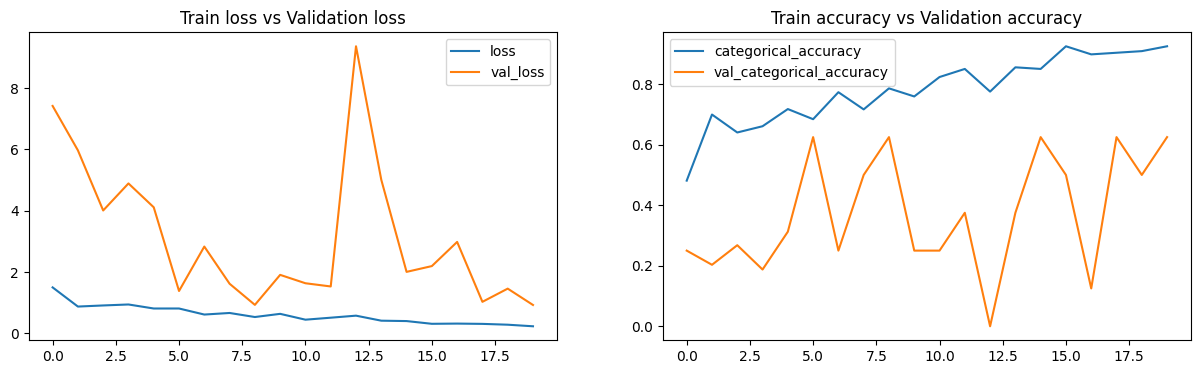

Max. Training Accuracy 0.9251337051391602
Max. Validaiton Accuracy 0.625


In [0]:
plotModelHistory(model1_history)

- Model Type - CONV3D Model (16 Frames with 20 Epochs)
- Total params: 2,067,621 
- Training Accuracy - 0.92
- Validation Accuracy - 0.625
- Inference : **Overfitting Model, lets try to change the Frames and Epochs**

### Model 2: Frames-30, Epocs-30

In [0]:
n_frames = 30
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 13, 48, 48, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 13, 48, 48, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 11, 23, 23, 32)   0         
 g3D)                                                            
                                                          

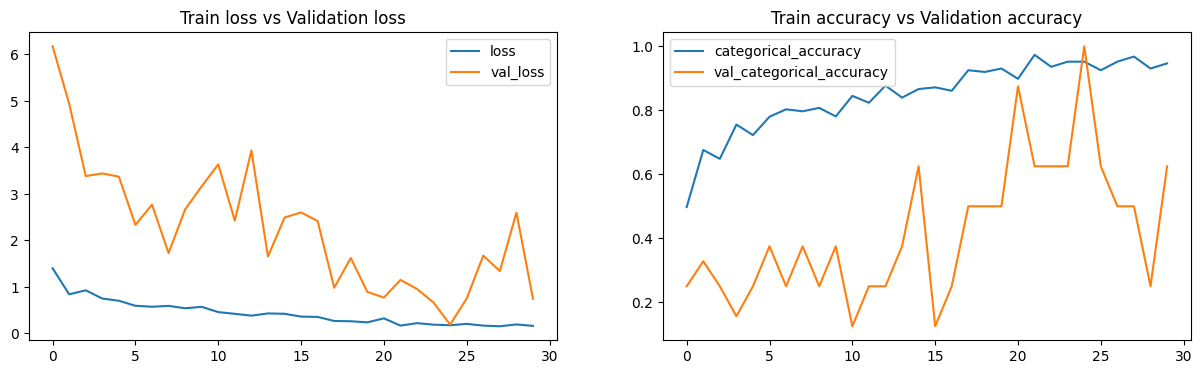

Max. Training Accuracy 0.9732620120048523
Max. Validaiton Accuracy 1.0


In [0]:
plotModelHistory(model2_history)

- Model Type - CONV3D Model (30 Frames with 30 Epochs)
- Total params: 9,006,245
- Training Accuracy - 0.97
- Validation Accuracy - 100
- Inference : **100% validation accuracy is a symptom of model memorised the pattern instead of generalizing, lets reduce the parameters further to see we can achieve the optimal accuracy**

### Model 3: Frames-30, Epocs-20, Reduced parameters

In [0]:
n_frames = 30
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")
model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 15, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 15, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 15, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 25, 25, 32)    0         
 g3D)                                                            
                                                          

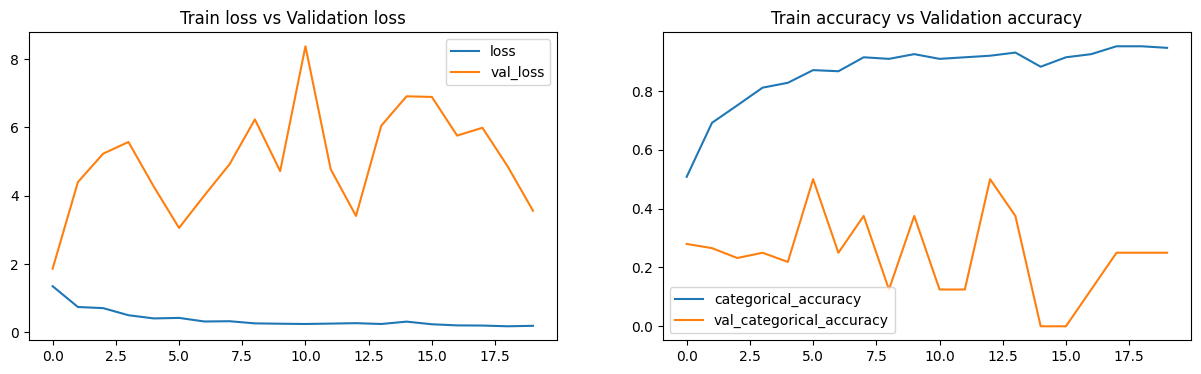

Max. Training Accuracy 0.9518716335296631
Max. Validaiton Accuracy 0.5


In [0]:
plotModelHistory(model3_history)

- Model Type - CONV3D Model (30 Frames with 30 Epochs)
- Total params: 5,618,245 - Reduced Parameters
- Training Accuracy - 0.95
- Validation Accuracy - 0.5
- Inference : **Model is performing well on Training but not validation**

### Model 4: Frames-20, Added one more  Conv3D/Maxpooling3D layer

In [0]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 20, 100, 100, 16)  1312      
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 10, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_19 (Conv3D)          (None, 10, 50, 50, 32)    13856     
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 5, 25, 25, 32)    0         
 g3D)                                                            
                                                          

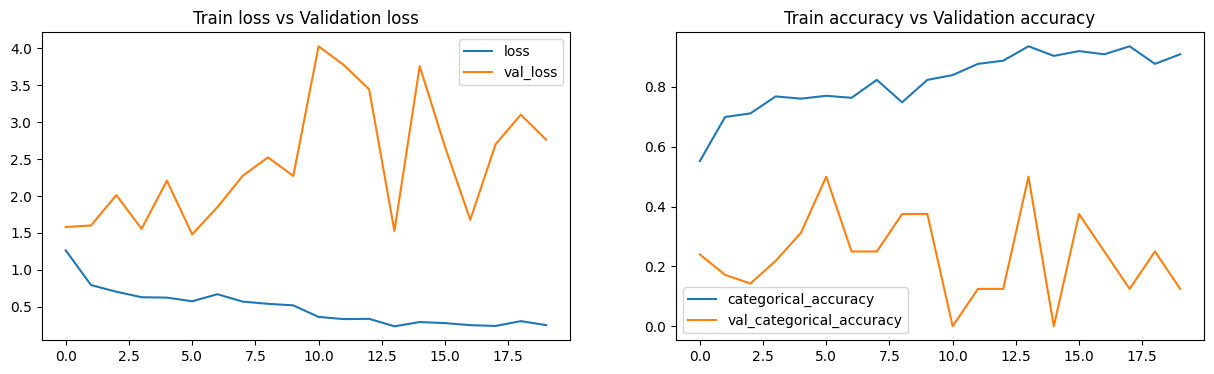

Max. Training Accuracy 0.9358288645744324
Max. Validaiton Accuracy 0.5


In [0]:
plotModelHistory(model4_history)

- Model Type - CONV3D Model (20 Frames with 20 Epochs)
- Total params: 1,907,909 - Added one more Conv3D and Maxpooling3D layer
- Training Accuracy - 0.935
- Validation Accuracy - 0.5
- Inference : **Model is performing well on Training but not validation**

### Model 5: Frames:20, Epocs-20, BS-64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling.

In [0]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),

    Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_3d5")
model5.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 20, 100, 100, 16)  400       
                                                                 
 batch_normalization_36 (Bat  (None, 20, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 10, 50, 50, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_23 (Conv3D)          (None, 10, 50, 50, 32)    4128      
                                                                 
 batch_normalization_37 (Bat  (None, 10, 50, 50, 32)   128       
 chNormalization)                                                
                                                          

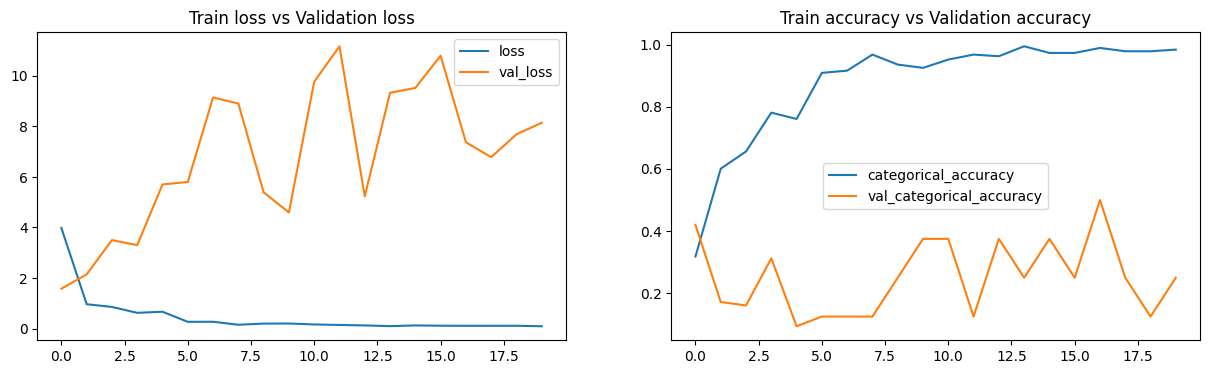

Max. Training Accuracy 0.9946523904800415
Max. Validaiton Accuracy 0.5


In [0]:
plotModelHistory(model5_history)

- Model Type - CONV3D Model (Frames:20, Epocs-20, BS-64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling)
- Total params: 1,301,045 
- Training Accuracy - 0.99
- Validation Accuracy - 0.5
- Inference : **Model is performing well on Training but not validation**

### Model 6: Conv2D+LSTM

In [0]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)  

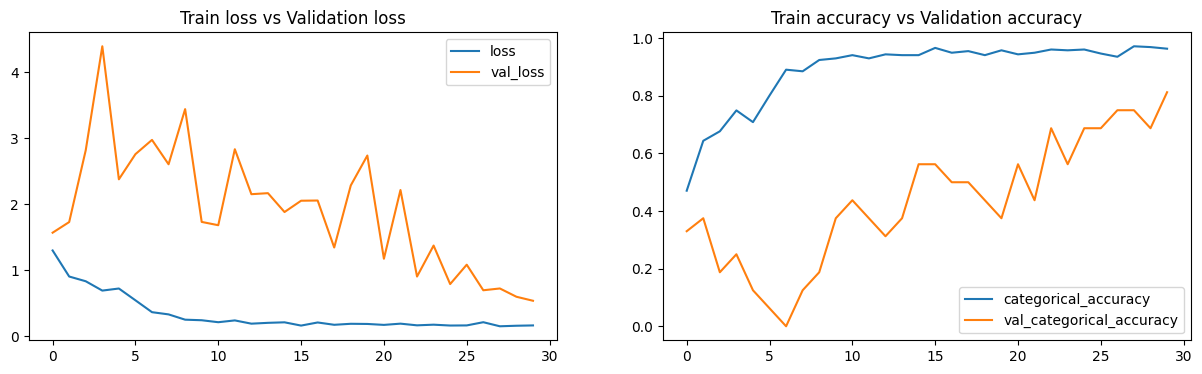

Max. Training Accuracy 0.9719887971878052
Max. Validaiton Accuracy 0.8125


In [0]:
plotModelHistory(model6_history)

- Model Type -  Conv2D+LSTM
- Total params: 3,084,133 
- Training Accuracy - 0.97
- Validation Accuracy - 0.81
- Inference : **Model is comparatively performing well on both training and validation**

### Model 7: CNN LSTM with GRU

In [0]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 20, 50, 50, 32)  

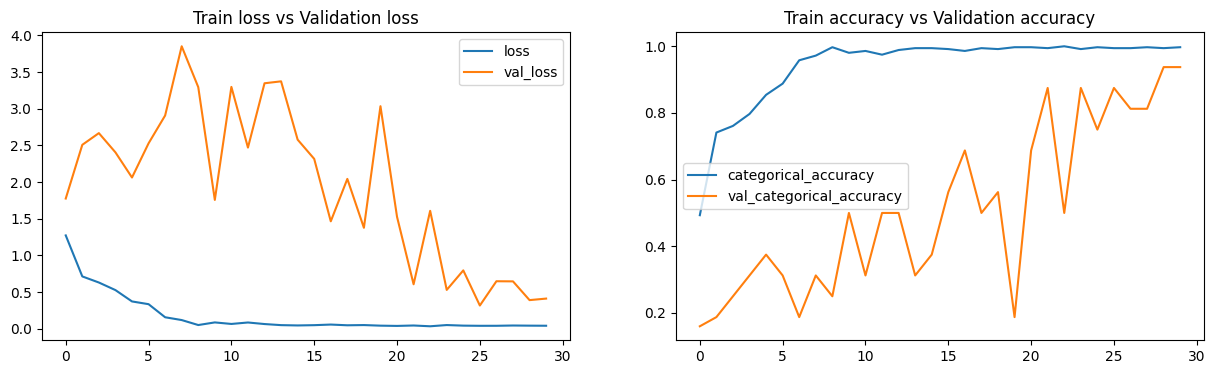

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.9375


In [0]:
plotModelHistory(model7_history)

- Model Type -  Conv2D+LSTM with GRU
- Total params: 2,429,285
- Training Accuracy - 0.99
- Validation Accuracy - 0.93
- Inference : **Model is performing very well on both training and validation**

### Model 8: Transfer Learning (MobileNet) with LSTM

In [0]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model8 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model8.layers:
    layer.trainable = False

model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model8.add(TimeDistributed(Flatten()))

model8.add(LSTM(256))
model8.add(Dropout(0.2))

model8.add(Dense(256,activation='relu'))
model8.add(Dropout(0.2))

model8.add(Dense(5, activation='softmax'))

model8.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

model8_history = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                     

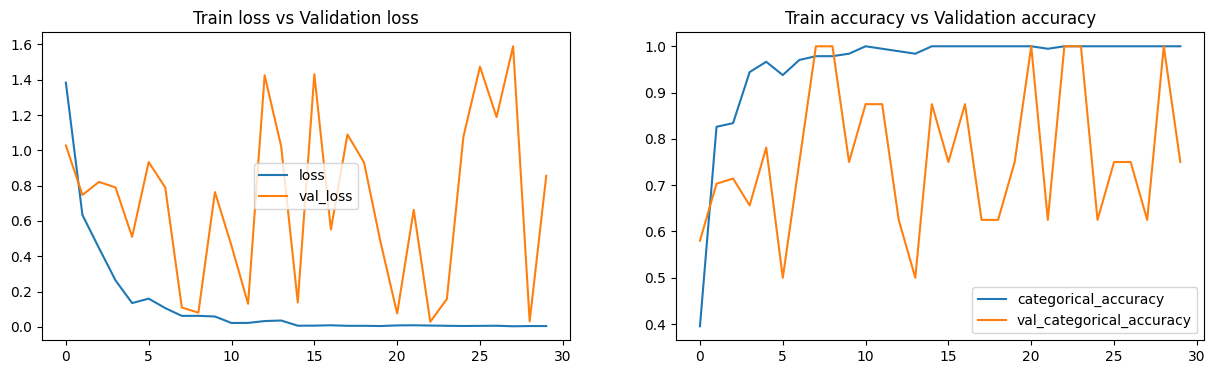

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [0]:
plotModelHistory(model8_history)

- Model Type -  Transfer Learning (MobileNet) with LSTM
- Total params: 4,611,781
- Training Accuracy - 1.0
- Validation Accuracy - 1.0
- Inference : **% of error is zero in the accuracy score which is sign of overfitting, 100% in training and validation is not a optimal model**

##Model 9: Transfer Learning (MobileNet) with GRU - 30 EPOCHS


In [0]:
# Rename the imported mobilenet module
import tensorflow.keras.applications.mobilenet as mobilenet_module

n_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch, validation_steps) = stepsperepoch(num_train_sequences, num_val_sequences, batch_size)

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model9 = Sequential([
    TimeDistributed(mobilenet_module.MobileNet(weights='imagenet', include_top=False), input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model9.layers:
    layer.trainable = False

model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model9.add(TimeDistributed(Flatten()))

model9.add(GRU(256))
model9.add(Dropout(0.2))

model9.add(Dense(256, activation='relu'))
model9.add(Dropout(0.2))

model9.add(Dense(5, activation='softmax'))

model9.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

model9_history = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                                      callbacks=callbacks_list, validation_data=val_generator,
                                      validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_53 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 256)            

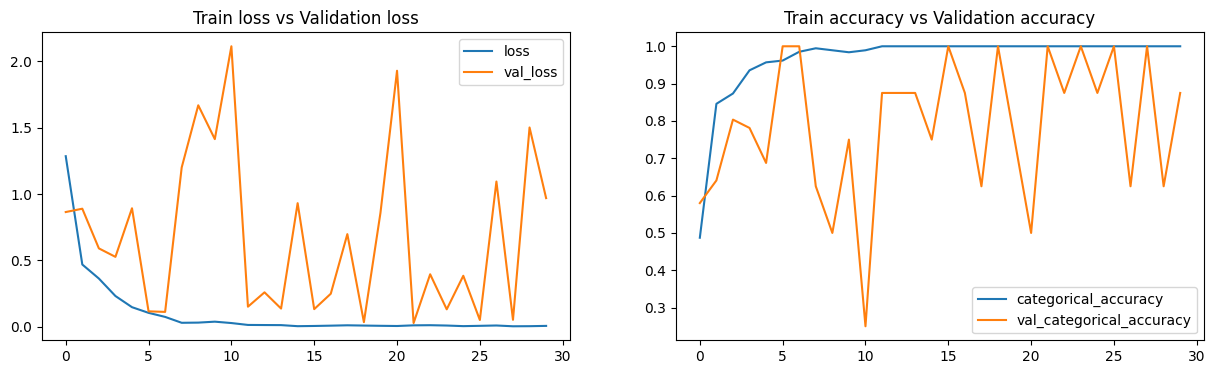

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [0]:
plotModelHistory(model9_history)

- Model Type -  Transfer Learning (MobileNet) with GRU
- Total params: 4,284,613
- Training Accuracy - 1.0
- Validation Accuracy - 1.0
- Inference : **% of error is zero in the accuracy score which is sign of overfitting, 100% in training and validation is not a optimal model**


#Final Observations : 

- **We can observe few models like MobileNet yielded 100 % training and validation accuracy, if the % of error is zero there are more chances the model memorised the pattern instead of generalizng**

- CNN LSTM with GRU is chosen as a Final Model because it has good training and validation score - 99% Training & 93% Validation

- The final model is saved and the h5 file is readily available for prediction - model-00030-0.04118-0.99720-0.41142-0.93750.h5

- Initially the the training performance was very slow, added 2 GPU's per node which improvised the performance

- Learning rate of the final model is : 8.0000e-06 
